# Overview 

The heart attack dataset is a simulated electronic health record from a simple point process model. This dataset records 1000 patients on 10 variables for each day over 10 years.

# Data Dictionary

| **Variable**              | **Var name** | **Type**                                                                 |
|---------------------------|--------------|--------------------------------------------------------------------------|
| Age                       | age          | Continuous                                                               |
| Cardiovascular Risk       | CVR          | Continuous, range from 0 to 1, indicating the baseline risk of CV events. Fixed for each patient. |
| **Medication**     |              |                                                                          |
| Beta Blocker              | BetaB        | Binary, patient's medication lasted for 1 year (365 days).               |
| Statins                   | Statins      | Binary, patient's medication lasted for 1 year (365 days).               |
| Acid Reducer              | AcidR        | Binary, patient's medication lasted for 1 year (365 days).               |
| Vioxx                     | Vioxx        | Binary, patient's medication lasted for 1 year (365 days).               |
| **Disease**               |              |                                                                          |
| Hypertension              | HT           | Binary, the disease lasts for 1 month from onset (30 days).              |
| High Cholesterol          | HC           | Binary, the disease lasts for 1 month from onset (30 days).              |
| Arthritis                 | Arthritis    | Binary, the disease lasts for 1 month from onset (30 days).              |
| **Primary Outcome**          |              |                                                                          |
| Myocardial Infarction     | MI           | Binary, it occurs then stops immediately.                                |


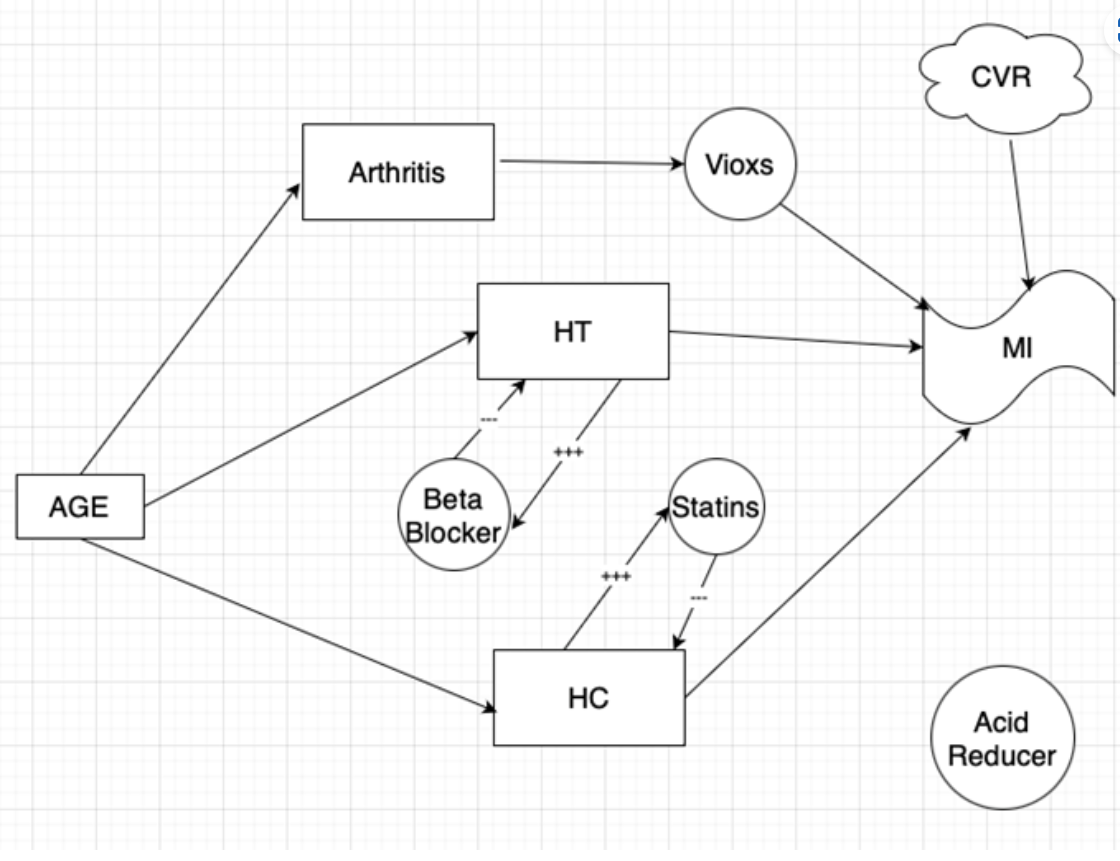

# Simulating Process

Patients are independent. For each patient, we follow the same process:

1. **Initialization:**
    - Determine **Cardiovascular Risk (CVR)**: Sample from a uniform distribution $U(0,1)$. This value is fixed over time.
    - Determine **Age**: Start from the patient's 40th birthday.
    - Initialize all other events as 0.

2. **Start Simulation:**
    - Set the starting day as $\text{day} = 0$ (the first day).
    - Initialize $t_0 = 0$.

3. **Daily Event Check:**
    - When $\text{day} = t_0$, check today’s status for the 8 events.
    - Only sample the events that are currently 0.

4. **Define Intensity Parameters:**
    - According to the relationships defined in the model, set the **intensity parameters** (rate of the exponential distribution) for the events that are 0.
    - Expoential distribution guarantees that events are expected to happen continuously and independently at a constant average rate.
    - Intensity scores allow you to model the randomness of when events happen, but in a way that reflects how risky or likely each event is for the patient. 
    - For the 8 binary variables, each has intensity parameter which is a function of its parents. We assume the time to event follows exponential distribution with parameter determined by current status of a patient.

5. **Sample Time to Next Occurrence:**
    - For each event that is 0, sample the **time to next occurrence** from the exponential distribution.

6. **Determine Next Event:**
    - Identify the next earliest event by finding the smallest sampled time to the event.
    - Let this event happen on $\text{day} = t$.

7. **Event Occurrence:**
    - When $\text{day} = t$, the picked event occurs (turn it to 1):
      1. If it is a **drug**, it stays 365 days (or another specified duration, e.g., 100/60/30 days).
      2. If it is a **disease**, it stays for 30 days.
      3. If it is **Myocardial Infarction (MI)**, it only happens on that day.

8. **Update Time:**
    - Set $t_0 = t$.

9. **Repeat:**
    - Repeat steps 3-8 until the end of the simulation.




# Expected Result

1000*3650*10 numpy array, where:
1)	1000 indicating 1000 patients
2)	3650 indicating 3650 days
3)	10 indicating 10 variables.


# Data Generation 

## Import libraries 

In [29]:
# import library
import numpy as np
import pandas as pd
from math import ceil
from sklearn.model_selection import train_test_split
import torch
import time
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


## Defining Intensity Function

In [30]:
def intensity_function(patient, var, current_day):
    # Retrieve the patient's age and Cardiovascular Risk (CVR) score for the current day
    age = patient['age'][current_day]
    cvr = patient['CVR'][current_day]

    # Calculate the patient's current decade of life, e.g., 40-49 years = 1st decade, 50-59 years = 2nd decade, etc.
    decade = ceil((age - 39) / 10)
    
    # Check the variable for which the intensity is being calculated
    if var == 'MI':  # Myocardial Infarction (Heart Attack)
        # Determine the influence of High Cholesterol (HC) and Hypertension (HT) on MI risk
        hc_influence = 0.001 if patient['HC'][current_day] else 0
        ht_influence = 0.001 if patient['HT'][current_day] else 0

        # Vioxx increases MI risk if the patient is taking it
        vioxx_influence = 2 if patient['Vioxx'][current_day] else 1

        # Calculate the intensity for MI risk
        para = (cvr/400 + hc_influence + ht_influence) * vioxx_influence
        return para

    elif var == 'HT':  # Hypertension
        # Beta Blockers reduce the risk of hypertension
        beta_influence = 1 if patient['BetaB'][current_day] else 2

        # Calculate the intensity for hypertension risk
        return (0.001 * decade) * beta_influence

    elif var == 'HC':  # High Cholesterol
        # Statins reduce the risk of high cholesterol
        statins_influence = 1 if patient['Statins'][current_day] else 2

        # Calculate the intensity for high cholesterol risk
        return (0.001 * decade) * statins_influence

    elif var == 'Arthritis':  # Arthritis
        # Arthritis risk depends on the patient's decade of life
        return 0.001 * decade  # Patients in their 4th decade have the same risk

    # For drug usage variables
    elif var == 'BetaB':  # Beta Blockers
        # Higher likelihood of taking Beta Blockers if the patient has hypertension
        return 0.005 if patient['HT'][current_day] else 0.001

    elif var == 'Statins':  # Statins
        # Higher likelihood of taking Statins if the patient has high cholesterol
        return 0.005 if patient['HC'][current_day] else 0.001

    elif var == 'AcidR':  # Acid Reducers
        # Constant likelihood of taking Acid Reducers
        return 0.001

    elif var == 'Vioxx':  # Vioxx (an anti-inflammatory drug)
        # Higher likelihood of taking Vioxx if the patient has arthritis
        return 0.008 if patient['Arthritis'][current_day] else 0.001

    # Default case if 'var' does not match any predefined cases
    print('else')
    return 10


## Function to Sample Next Event

In [31]:
def sample_next_event(patient, current_day):

    # Initialize the next event day to be beyond the simulation period (total_days + 1)
    next_event_day = total_days + 1
    next_event_type = None  # Initialize with no event type

    # Loop through each variable of interest (e.g., diseases or medications)
    for var in poi_var:

        # Skip the variable if:
        # 1. It's a drug and the patient is already taking it.
        # 2. It's a clinical condition (HT, HC, Arthritis, MI) that the patient is currently experiencing.
        if (var in drug and patient[var][current_day]) or \
           (var in ['HT', 'HC', 'Arthritis'] and patient[var][current_day]) or \
           (var == 'MI' and patient[var][current_day]):
            continue  # Move to the next variable

        # Calculate the rate (λ) for the event using the intensity function, and halve it
        rate = intensity_function(patient, var, current_day) / 2

        # Sample the time to the next event from an exponential distribution with the given rate
        # max(rate, 1e-9) ensures that the rate is never zero (avoiding division by zero)
        time_to_next_event = np.random.exponential(1 / max(rate, 1e-9))

        # If the sampled time results in an earlier event than the current next_event_day, update it
        if current_day + time_to_next_event < next_event_day:
            next_event_day = int(current_day + time_to_next_event)  # Set the day of the next event
            next_event_type = var  # Set the type of the next event

    # Return the day and type of the next event
    return next_event_day, next_event_type

# Function to update the patient's status based on the type of event that occurred
def update_patient_status(patient, event_type, current_day):
    
    # If the event is a drug being administered
    if event_type in drug:
        # Set the patient's status to 1 (indicating the drug is being taken) for the next 365 days
        patient[event_type][current_day:current_day+365] = 1
    
    # If the event is a clinical condition (Hypertension, High Cholesterol, Arthritis)
    elif event_type in ['HT', 'HC', 'Arthritis']:
        # Set the patient's status to 1 (indicating the condition is active) for the next 30 days
        patient[event_type][current_day:current_day+30] = 1
    
    # If the event is a Myocardial Infarction (MI)
    elif event_type == 'MI':
        # Set the patient's status to 1 (indicating an MI occurred) only on the current day
        patient[event_type][current_day] = 1


## Function to Simulate Data

In [32]:
def simulate_patients(n_pat, total_days, poi_var, dtype, seed=None):
    """
    Simulates the health trajectory of a population of patients over a given period.

    Parameters:
    - n_pat: Number of patients to simulate.
    - total_days: Total number of days to simulate.
    - poi_var: List of variables of interest (e.g., diseases or medications).
    - dtype: The data type used for the numpy structured array.
    - seed: Optional seed for random number generation to ensure reproducibility.

    Returns:
    - dat: A 3-dimensional numpy array containing the simulated data.
    - elapsed_time: The time taken to run the simulation.
    """
    
    # Set the seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)

    # List to store individual patient records
    pat_list = []

    # Start timing the simulation process
    start_time = time.time()

    # Loop over each patient
    for i in range(n_pat):
        print(f"Simulating patient {i+1}/{n_pat}")

        # Initialize this patient's record
        patient = np.zeros((total_days,), dtype=dtype)

        # Set age and cardiovascular risk (CVR)
        patient['age'] = np.array([40 + day // 365 for day in range(total_days)])
        patient['CVR'] = np.random.uniform(0, 1, 1)
        
        # Initialize all variables of interest to zero
        for var in poi_var:
            patient[var] = 0

        # Simulate events starting from day 0
        day = 0
        while day < total_days:
            # Determine the next event and its timing
            next_day, event_type = sample_next_event(patient, day)

            # If the event occurs within the simulation period, update the patient's status
            if next_day < total_days:
                update_patient_status(patient, event_type, next_day)
                day = next_day
            else:
                break  # Exit if no more events occur within the period

        # Add the simulated patient data to the list
        pat_list.append(patient)

    # Convert the list of patient records into a numpy array
    pat_array = np.array(pat_list)

    # Prepare a 3-dimensional array to hold the final data
    d1 = n_pat  # Number of patients
    d2 = total_days  # Number of days
    d3 = 2 + len(poi_var)  # Age, CVR, plus the variables of interest

    dat = np.empty((d1, d2, d3), dtype=float)

    # Populate the 3D array with age, CVR, and variables of interest
    for i in range(d1):
        for j in range(d2):
            dat[i, j, 0] = pat_array['age'][i][j]  # Age
            dat[i, j, 1] = pat_array['CVR'][i][j]  # CVR
            for k, var in enumerate(poi_var):
                dat[i, j, 2 + k] = pat_array[var][i][j]  # Variables of interest

    # End timing the simulation process
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Simulation completed in {elapsed_time:.2f} seconds")

    return dat, elapsed_time


## Data Simulation

In [33]:
# parameters for simulation
seed = 123
n_pat = 1000
total_days = 10 * 365
poi_var = ['BetaB', 'Statins', 'AcidR', 'Vioxx', 'HT', 'HC', 'Arthritis', 'MI']
drug = ['BetaB', 'Statins', 'AcidR', 'Vioxx']
dtype = [('age', int), ('CVR', float)] + [(var, int) for var in poi_var]

data = simulate_patients(n_pat, total_days, poi_var, dtype, seed=seed)[0]

Simulating patient 1/1000
Simulating patient 2/1000
Simulating patient 3/1000
Simulating patient 4/1000
Simulating patient 5/1000
Simulating patient 6/1000
Simulating patient 7/1000
Simulating patient 8/1000
Simulating patient 9/1000
Simulating patient 10/1000
Simulating patient 11/1000
Simulating patient 12/1000
Simulating patient 13/1000
Simulating patient 14/1000
Simulating patient 15/1000
Simulating patient 16/1000
Simulating patient 17/1000
Simulating patient 18/1000
Simulating patient 19/1000
Simulating patient 20/1000
Simulating patient 21/1000
Simulating patient 22/1000
Simulating patient 23/1000
Simulating patient 24/1000
Simulating patient 25/1000
Simulating patient 26/1000
Simulating patient 27/1000
Simulating patient 28/1000
Simulating patient 29/1000
Simulating patient 30/1000
Simulating patient 31/1000
Simulating patient 32/1000
Simulating patient 33/1000
Simulating patient 34/1000
Simulating patient 35/1000
Simulating patient 36/1000
Simulating patient 37/1000
Simulating

Simulating patient 192/1000
Simulating patient 193/1000
Simulating patient 194/1000
Simulating patient 195/1000
Simulating patient 196/1000
Simulating patient 197/1000
Simulating patient 198/1000
Simulating patient 199/1000
Simulating patient 200/1000
Simulating patient 201/1000
Simulating patient 202/1000
Simulating patient 203/1000
Simulating patient 204/1000
Simulating patient 205/1000
Simulating patient 206/1000
Simulating patient 207/1000
Simulating patient 208/1000
Simulating patient 209/1000
Simulating patient 210/1000
Simulating patient 211/1000
Simulating patient 212/1000
Simulating patient 213/1000
Simulating patient 214/1000
Simulating patient 215/1000
Simulating patient 216/1000
Simulating patient 217/1000
Simulating patient 218/1000
Simulating patient 219/1000
Simulating patient 220/1000
Simulating patient 221/1000
Simulating patient 222/1000
Simulating patient 223/1000
Simulating patient 224/1000
Simulating patient 225/1000
Simulating patient 226/1000
Simulating patient 2

## Data Visualization 

### Average proportion of Patients with Certain Event/Drug Over Time  

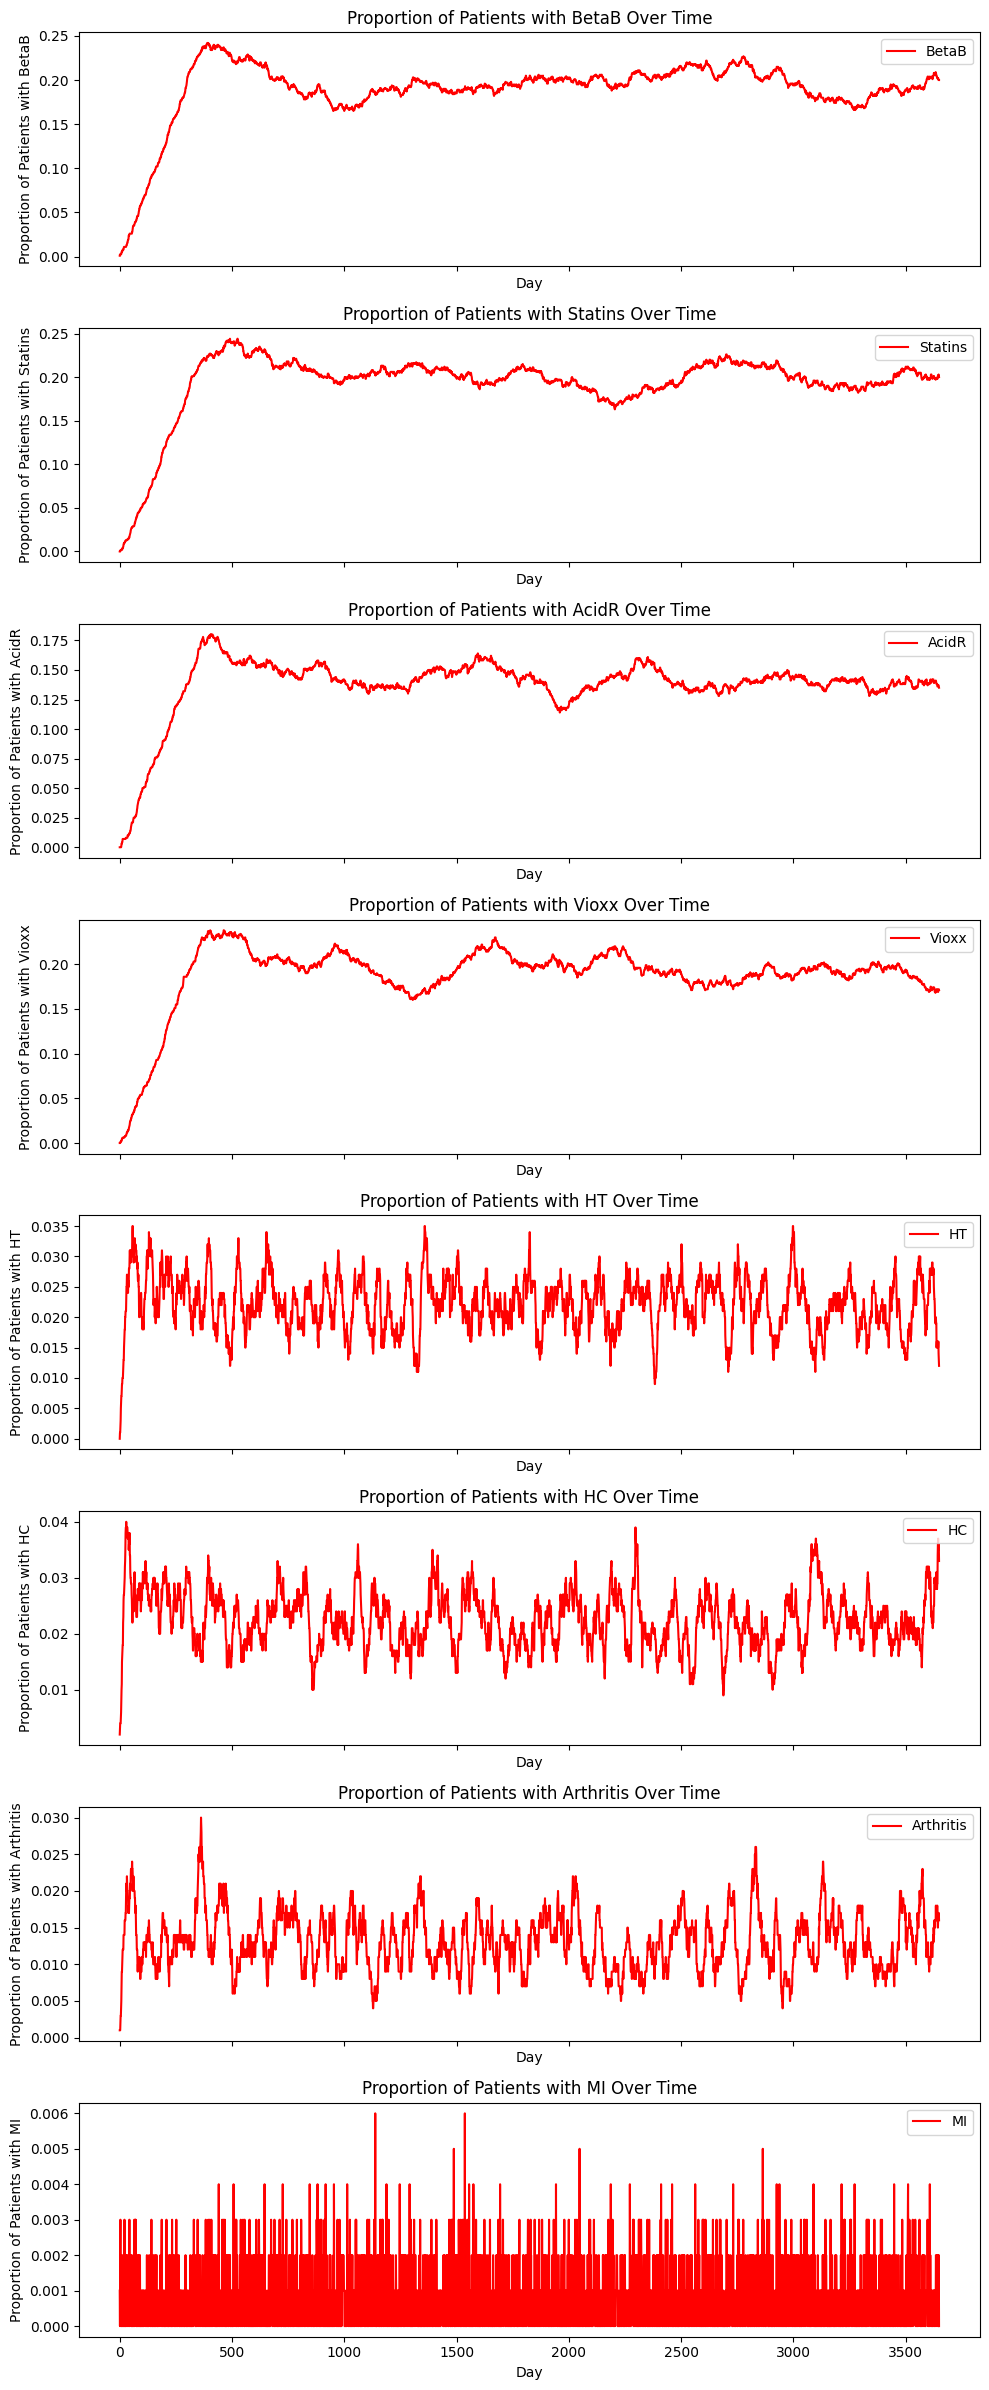

In [44]:
plot_var = ['BetaB', 'Statins', 'AcidR', 'Vioxx', 'HT', 'HC', 'Arthritis', 'MI']
# Number of variables to plot
n_vars = len(poi_var)

# Initialize a figure with multiple subplots
fig, axs = plt.subplots(n_vars, 1, figsize=(10, 3 * n_vars), sharex=True)

# Iterate through each variable
for i, var in enumerate(poi_var):
    # Determine the index of the variable in the data array
    var_index = i + 2  # Assuming that the first two columns are 'age' and 'CVR'
    
    # Calculate the proportion of patients with the event on each day
    event_occurrences = np.mean(data[:, :, var_index], axis=0)
    
    # Plot the event occurrences over time
    axs[i].plot(event_occurrences, color='red')
    axs[i].set_title(f'Proportion of Patients with {poi_var[i]} Over Time')
    axs[i].set_xlabel('Day')
    axs[i].set_ylabel(f'Proportion of Patients with {poi_var[i]}')
    axs[i].legend([poi_var[i]], loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Drug variables have similar pattern which is expected: they first increases with age and then fluctuate.  The similarity between Beta B and Stain result from indentical intensity funciton between them as well as HT and HC. 

Comorbidity variables have similar pattern which is expected: they first increases with age and then fluctuate. We see a bigger fluctuation in comorbidities because of the difference in duration of the effect(comorbidities: 30 days, Drug: 360 days) 

MI is affected by HC HT CVR and Vioxx. Thus it has no obvious trend since CVR is constant for a patient overtime. 

Reason's for fluctuation: the presence of the comorbidities -> taking drug -> decrease probability -> no drug -> increase probability.

### Events for a patient 

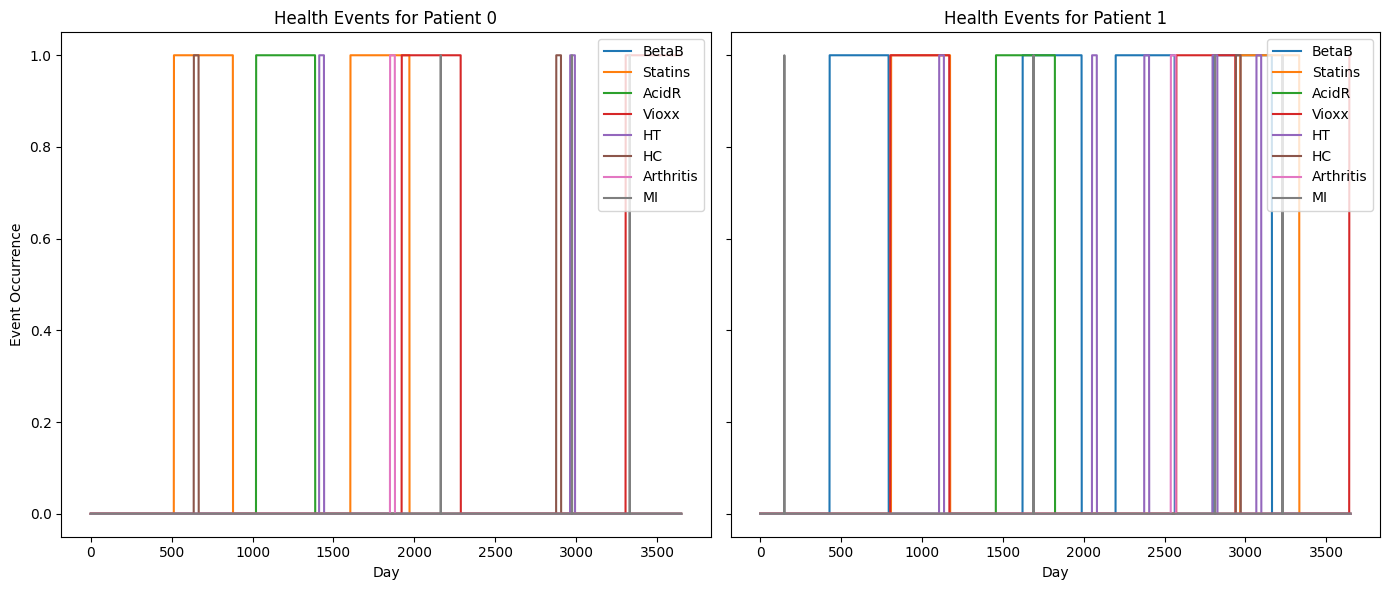

In [35]:
# Initialize the figure and axes for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for the first patient
patient_index = 0  
days = np.arange(data.shape[1])
for i, var in enumerate(poi_var):
    axs[0].plot(days, data[patient_index, :, 2 + i], label=var)

axs[0].set_title(f'Health Events for Patient {patient_index}')
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Event Occurrence')
axs[0].legend(loc='upper right')

# Plot for the second patient
patient_index = 1  
days = np.arange(data.shape[1])
for i, var in enumerate(poi_var):
    axs[1].plot(days, data[patient_index, :, 2 + i], label=var)

axs[1].set_title(f'Health Events for Patient {patient_index}')
axs[1].set_xlabel('Day')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

### Average Event Count

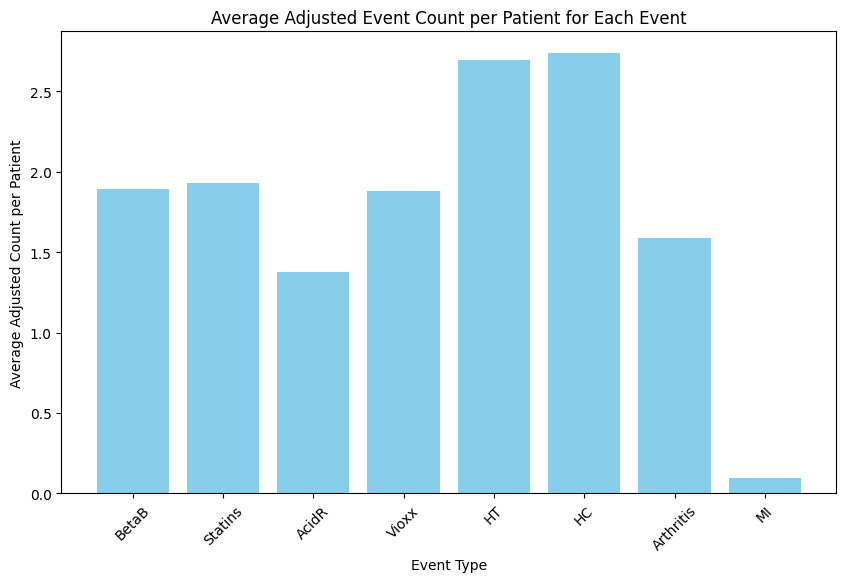

In [54]:
# Extract the event data (starting from the 3rd column, as the first two are 'age' and 'CVR')
event_data = data[:, :, 2:]  # Shape: (n_pat, total_days, len(poi_var))

# Identify the indices for drugs and diseases
drug_indices = [poi_var.index(drug) for drug in ['BetaB', 'Statins', 'AcidR', 'Vioxx']]
disease_indices = [poi_var.index(disease) for disease in ['HT', 'HC', 'Arthritis', 'MI']]

# Sum the events for each patient over the simulation period
event_counts = np.sum(event_data, axis=1)  # Shape: (n_pat, len(poi_var))

# Adjust event counts by dividing drugs by 365 and diseases by 30
for idx in drug_indices:
    event_counts[:, idx] /= 365.0

for idx in disease_indices:
    event_counts[:, idx] /= 30.0

# Calculate the average event count per event across all patients
average_event_counts = np.mean(event_counts, axis=0)  # Shape: (len(poi_var),)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(poi_var, average_event_counts, color='skyblue')
plt.xlabel('Event Type')
plt.ylabel('Average Adjusted Count per Patient')
plt.title('Average Adjusted Event Count per Patient for Each Event')
plt.xticks(rotation=45)
plt.show()

### CVR and MI

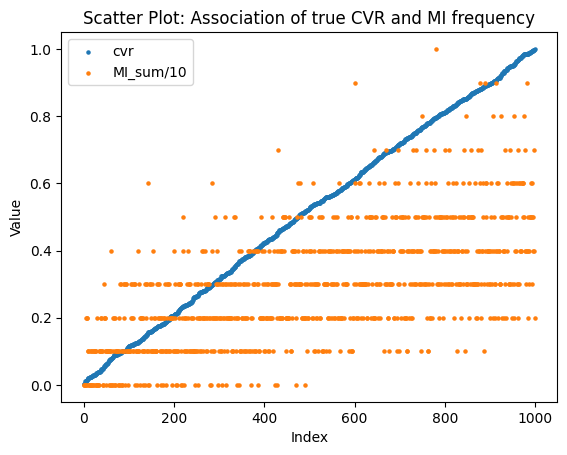

In [49]:
cvr_list = data[:, 0, 1]
MI_events = data[:, :, 9]
MI_total = MI_events.sum(axis=1)

sorted_indices = np.argsort(cvr_list)
MI_total_sorted = MI_total[sorted_indices]/10
indices = np.arange(len(cvr_list))

point_size = 5
plt.scatter(indices, cvr_list[sorted_indices], label='cvr', s=point_size)
plt.scatter(indices, MI_total_sorted, label='MI_sum/10', s=point_size)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot: Association of true CVR and MI frequency')
plt.legend()
plt.show()

People with more CVR will have more MI. 

# Save Dataset

In [55]:
# Save the dataset to a .npy file
np.save('simulated_dataset.npy', data)

# Discussion

What is the definition of CVR, and How can our model learn CVR? 
- Will CVR also causing other complication, considering they have common risk factor such as obesity (CKM) 

Why Viox is not decreasing the occurance of Arthritis
